# **Model 1**

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Loss=1.0369, Accuracy=73.57%
Epoch 2: Loss=0.6071, Accuracy=80.93%
Epoch 3: Loss=0.5337, Accuracy=82.25%
Epoch 4: Loss=0.4972, Accuracy=83.16%
Epoch 5: Loss=0.4750, Accuracy=83.72%

FINAL TEST RESULTS
Average Loss: 0.4479
Accuracy: 84.36%
Correct/Total: 8436/10000

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.77      0.79      1000
     Trouser       0.99      0.95      0.97      1000
    Pullover       0.77      0.80      0.79      1000
       Dress       0.78      0.85      0.81      1000
        Coat       0.75      0.75      0.75      1000
      Sandal       0.95      0.90      0.92      1000
       Shirt       0.63      0.58      0.61      1000
     Sneaker       0.88      0.93      0.90      1000
         Bag       0.94      0.96      0.95      1000
  Ankle boot       0.93      0.93      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     1000

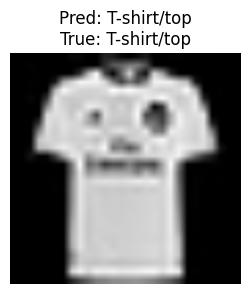

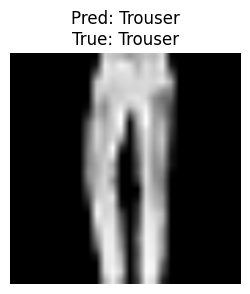

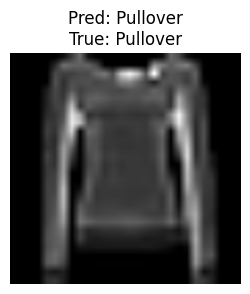

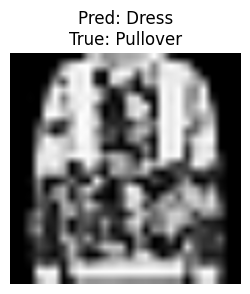

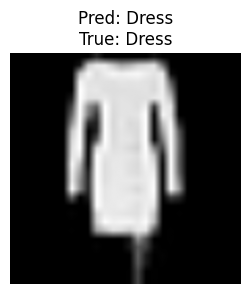

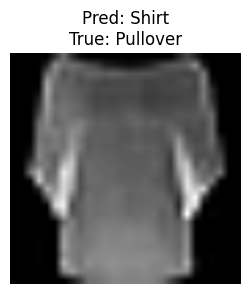

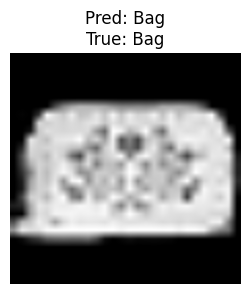

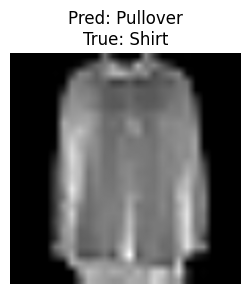

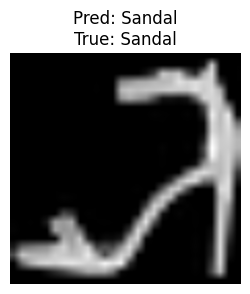

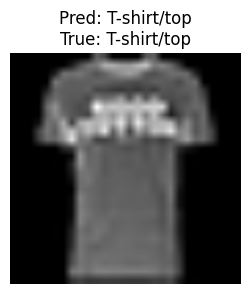

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# enabling GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1:].values.reshape(28, 28).astype(np.uint8)
        label = self.data.iloc[idx, 0]

        if self.transform:
            image = self.transform(image)

        return image, label

class ResizeAndReplicateChannels:
    def __call__(self, img):

        img = torch.from_numpy(img).float() / 255.0

        img = img.unsqueeze(0)

        img = F.interpolate(img.unsqueeze(0), size=(224, 224), mode='bilinear').squeeze(0)

        img = img.repeat(3, 1, 1)
        return img


transform = ResizeAndReplicateChannels()
train_dataset = FashionMNISTDataset("fashion-mnist_train.csv", transform=transform)
test_dataset = FashionMNISTDataset("fashion-mnist_test.csv", transform=transform)


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


def get_pretrained_model():
    model = models.resnet50(pretrained=True)

    # Freeze all layers except the final one
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final layer
    model.fc = nn.Linear(model.fc.in_features, 10)
    model.fc.requires_grad = True

    return model.to(device)

model = get_pretrained_model()


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)


def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        print(f"Epoch {epoch+1}: Loss={running_loss/len(train_loader):.4f}, Accuracy={acc:.2f}%")

def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader)

    print("\n" + "="*50)
    print("FINAL TEST RESULTS")
    print("="*50)
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Correct/Total: {correct}/{total}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    return accuracy, avg_loss


def plot_predictions(model, test_loader, num_images=10):
    model.eval()
    images_plotted = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(len(images)):
                if images_plotted >= num_images:
                    return

                plt.figure(figsize=(3,3))
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                plt.imshow(img[:,:,0], cmap='gray')
                plt.title(f"Pred: {class_names[predicted[i]]}\nTrue: {class_names[labels[i]]}")
                plt.axis('off')
                plt.show()

                images_plotted += 1


train_model(model, train_loader, criterion, optimizer, num_epochs=5)
test_accuracy, test_loss = evaluate_model(model, test_loader, criterion)


plot_predictions(model, test_loader)


final_layer_weights = model.fc.state_dict()
torch.save(final_layer_weights, 'final_layer_weights.pth')

# **Description**

This code is a major improvment over my earlier attempts, In my earlier attempts I was trying to resize the image and save to the disc, even though I escaped memory crashing by processing in chunks, I later ran into same problem while reading the resized image(which also consumed a lot of disc space).

**What this code Does ?**

This attempt on the other hand instead of pre-processing and saving all transformed images to disk (which consumed significant storage), we now transform images on-the-fly during training.

This gives us very good result, as previously I was struggling with even nearest intepolation, now this enabled bilinear interpolation.

# **Model 2**

# **Furthur Improvments**

In this attempt I will try to use the ResNet50 with more unfreezed layers, will add dropouts to avoid overfitting and also use Learning rate scheduling.

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]
Epoch 1/10: 100%|██████████| 469/469 [03:54<00:00,  2.00it/s, loss=0.4, acc=85.64%]


Epoch 1 complete. Loss: 0.3998, Accuracy: 85.64%


Epoch 2/10: 100%|██████████| 469/469 [03:56<00:00,  1.98it/s, loss=0.267, acc=90.44%]


Epoch 2 complete. Loss: 0.2667, Accuracy: 90.44%


Epoch 3/10: 100%|██████████| 469/469 [03:56<00:00,  1.98it/s, loss=0.229, acc=91.72%]


Epoch 3 complete. Loss: 0.2287, Accuracy: 91.72%


Epoch 4/10: 100%|██████████| 469/469 [03:56<00:00,  1.98it/s, loss=0.209, acc=92.53%]


Epoch 4 complete. Loss: 0.2089, Accuracy: 92.53%


Epoch 5/10: 100%|██████████| 469/469 [03:56<00:00,  1.98it/s, loss=0.188, acc=93.25%]


Epoch 5 complete. Loss: 0.1876, Accuracy: 93.25%


Epoch 6/10: 100%|██████████| 469/469 [03:56<00:00,  1.98it/s, loss=0.171, acc=93.72%]


Epoch 6 complete. Loss: 0.1714, Accuracy: 93.72%


Epoch 7/10: 100%|██████████| 469/469 [03:56<00:00,  1.98it/s, loss=0.162, acc=94.10%]


Epoch 7 complete. Loss: 0.1615, Accuracy: 94.10%


Epoch 8/10: 100%|██████████| 469/469 [03:56<00:00,  1.98it/s, loss=0.152, acc=94.53%]


Epoch 8 complete. Loss: 0.1522, Accuracy: 94.53%


Epoch 9/10: 100%|██████████| 469/469 [03:56<00:00,  1.98it/s, loss=0.143, acc=94.85%]


Epoch 9 complete. Loss: 0.1431, Accuracy: 94.85%


Epoch 10/10: 100%|██████████| 469/469 [03:56<00:00,  1.98it/s, loss=0.132, acc=95.17%]


Epoch 10 complete. Loss: 0.1322, Accuracy: 95.17%


Evaluating: 100%|██████████| 79/79 [00:28<00:00,  2.78it/s, acc=93.70%]



FINAL TEST RESULTS
Average Loss: 0.1969
Accuracy: 93.70%
Correct/Total: 9370/10000

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.91      0.87      0.89      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.94      0.90      0.92      1000
       Dress       0.92      0.95      0.93      1000
        Coat       0.87      0.94      0.91      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.84      0.81      0.82      1000
     Sneaker       0.97      0.95      0.96      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.95      0.98      0.96      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000


Confusion Matrix:
[[874   0  12  17   3   0  88   0   6   0]
 [  0 989   0   8   2   0   1   0   0   0]
 [ 23   1 898  13  34   0  3

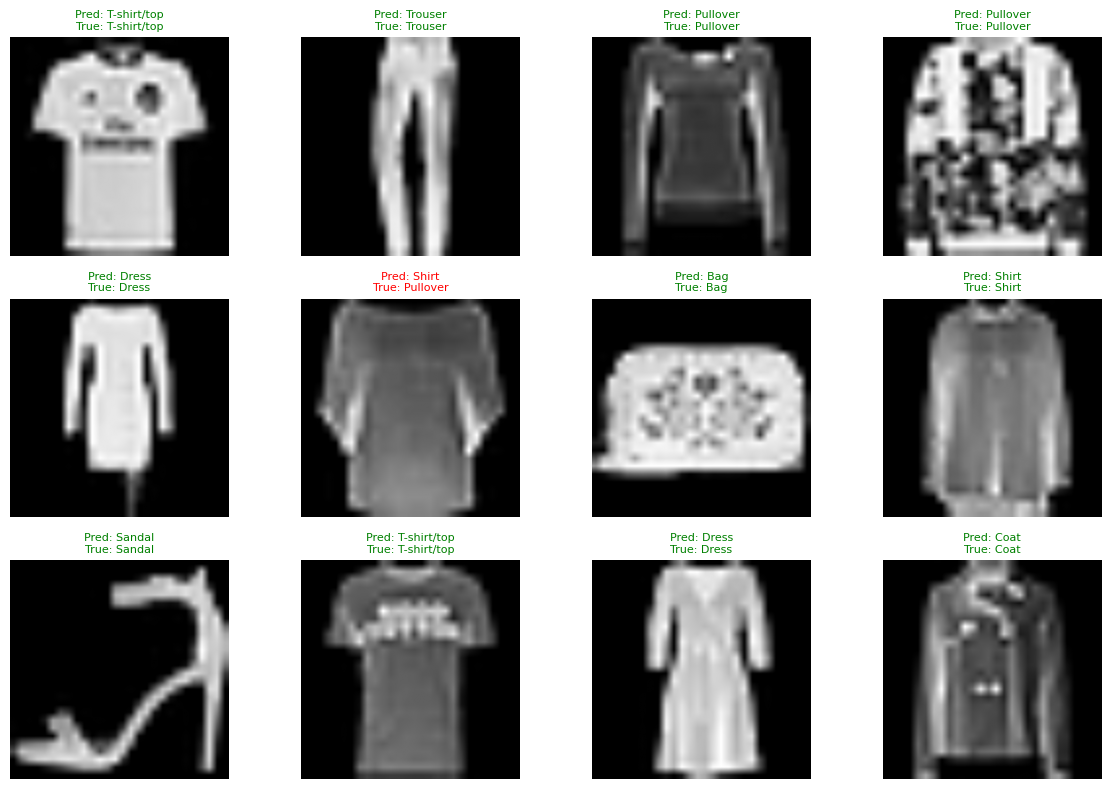

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.transforms.functional import rotate


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, train=True, transform=None):
        self.data = pd.read_csv(csv_file)
        self.train = train
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1:].values.reshape(28, 28).astype(np.uint8)
        label = self.data.iloc[idx, 0]

        if self.transform:
            image = self.transform(image)

        return image, label

class EnhancedResizeTransform:
    def __init__(self, train=True):
        self.train = train

    def __call__(self, img):

        img = torch.from_numpy(img).float() / 255.0
        img = img.unsqueeze(0)


        if self.train:

            if torch.rand(1) > 0.5:
                img = torch.flip(img, [2])


            angle = float(torch.empty(1).uniform_(-15, 15))
            img = rotate(img.unsqueeze(0), angle).squeeze(0)


        img = F.interpolate(img.unsqueeze(0), size=(224, 224), mode='bilinear').squeeze(0)


        img = img.repeat(3, 1, 1)


        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = (img - mean) / std

        return img


train_transform = EnhancedResizeTransform(train=True)
test_transform = EnhancedResizeTransform(train=False)

train_dataset = FashionMNISTDataset("fashion-mnist_train.csv", train=True, transform=train_transform)
test_dataset = FashionMNISTDataset("fashion-mnist_test.csv", train=False, transform=test_transform)


batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


def get_enhanced_model():

    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)


    for param in model.parameters():
        param.requires_grad = False


    for param in model.layer4.parameters():
        param.requires_grad = True


    model.fc = nn.Sequential(
        nn.Dropout(0.5),  # Add dropout for regularization
        nn.Linear(model.fc.in_features, 10)
    )

    return model.to(device)

model = get_enhanced_model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
], weight_decay=1e-5)  # Add L2 regularization

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)


def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({
                'loss': running_loss/(pbar.n+1),
                'acc': f'{100*correct/total:.2f}%'
            })

        epoch_acc = 100 * correct / total
        scheduler.step(epoch_acc)  # Update learning rate

        # Save best model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_model.pth')

        print(f"Epoch {epoch+1} complete. Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_acc:.2f}%")


train_model(model, train_loader, criterion, optimizer, num_epochs=10)


def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Evaluating')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({
                'acc': f'{100*correct/total:.2f}%'
            })

    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader)

    print("\n" + "="*50)
    print("FINAL TEST RESULTS")
    print("="*50)
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Correct/Total: {correct}/{total}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))

    return accuracy, avg_loss


model.load_state_dict(torch.load('best_model.pth'))
test_accuracy, test_loss = evaluate_model(model, test_loader, criterion)


def plot_predictions(model, test_loader, num_images=12):
    model.eval()
    images_plotted = 0

    plt.figure(figsize=(12, 8))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(len(images)):
                if images_plotted >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return

                plt.subplot(3, 4, images_plotted+1)
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
                plt.imshow(img[:,:,0], cmap='gray')
                title_color = 'green' if predicted[i] == labels[i] else 'red'
                plt.title(f"Pred: {class_names[predicted[i]]}\nTrue: {class_names[labels[i]]}",
                         color=title_color, fontsize=8)
                plt.axis('off')

                images_plotted += 1


plot_predictions(model, test_loader)


torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'full_model_checkpoint.pth')

We see wonderfull results, and very improved accuracy.